In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
from efn_util import get_flowdict, get_flowstring, get_ef_dimensionalities
import os
import seaborn as sns
import pandas as pd

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


ImportError: cannot import name 'get_flowdict'

In [2]:
def report_model_status(fname, R2nz, KLnz, R2nans, KLnans, file_exists):
    if (not file_exists):
        return 1;
    elif (R2nz > 0 or KLnz > 0):
        return 2;
    elif (R2nans > 0):
        return 3;
    return 4


In [8]:
def get_R2_elbo(fname, max_iters):
    file_exists = False;
    if (not os.path.isfile(fname)):
        R2vals = np.nan;
        elbovals = np.nan;
        K = 1;
    else:
        file_exists = True;
        X = np.load(fname);
        check_rate = X['check_rate'];
        num_checks = X['test_R2s'].shape[0];
        nits = check_rate*num_checks;
        opt_ind = int((max_iters/nits)*num_checks)-1;
        K = X['test_R2s'].shape[1];
        R2vals = X['test_R2s'][opt_ind,:];
        elbovals = X['test_elbos'][opt_ind,:];
        params = X['eta_test_draw_params'][()];
        Sigma = params['Sigmas'][0];
        mu = params['mus'][0];
        xs = params['xs'];
        Ns = params['Ns'];
        A1 = np.dot(mu.T, np.dot(np.linalg.inv(Sigma), mu))/2.0 + np.log(np.linalg.det(Sigma));
        for i in range(K):
            N_i = int(Ns[i]);
            x_i = xs[i,:,:N_i];
            fact_x_i = np.zeros((D,N_i));
            for j in range(D):
                for jj in range(N_i):
                    fact_x_i[j] = np.math.factorial(x_i[j, jj]);
            h1h2 = np.log(np.prod(np.prod(fact_x_i)) / ((2*np.pi)**(D/2)))
            elbovals[i] = elbovals[i] +h1h2 - A1;
    R2nz_orig = np.sum(R2vals == 0);
    KLnz_orig = np.sum(elbovals == 0);
    R2nans = np.sum(np.isnan(R2vals));
    KLnans = np.sum(np.isnan(elbovals));
    if (R2nz_orig == K and KLnz_orig == K):
        print(fname);
        print('looking back in time for latest R2 or KL');
        found = False;
        dec = 1;
        while (not found):
            R2vals = X['test_R2s'][opt_ind-dec,:];
            elbovals = X['test_elbos'][opt_ind-dec,:];
            R2nz = np.sum(R2vals == 0);
            KLnz = np.sum(KLvals == 0);
            found = not (R2nz == K and KLnz == K);
            dec = dec+1;
        print('found it at %d' % int((opt_ind-(dec+1))*check_rate));
        
        
    #print(R2nz, KLnz, R2nans, KLnans);
    if (R2nz_orig > 0 or R2nans > 0):
        status = report_model_status(fname, R2nz_orig, KLnz_orig, R2nans, KLnans, file_exists);
    else:
        status = 0;
    #print(R2vals.shape, elbovals.shape, status);
    return R2vals, elbovals, status;

def log_fname(fname, status, status_lists):
    if status != 0:
        status_lists[status-1].append(fname);
        
        
        
exp_fam = 'prp_tn';
model_info = {'subclass':'VI', 'extrastr':''};

datadir = '/Users/sbittner/Documents/efn/results/Fig5/VI/';
max_iters = 20000;

D = 20;
Rs = [1, 5, 10, 20];
Ns = [10, 20, 50, 100];
num_Rs = len(Rs);
num_Ns = len(Ns);
    
num_rs = 10;

VI_Rsweep_R2s = np.zeros((num_Rs, num_rs));
VI_Nsweep_R2s = np.zeros((num_Ns, num_rs));
VI_Rsweep_elbos = np.zeros((num_Rs, num_rs));
VI_Nsweep_elbos = np.zeros((num_Ns, num_rs));

not_started = [];
in_progress = [];
unstable = [];
status_lists = [not_started, in_progress, unstable];

N = 50;
for i in range(num_Rs):
    R = Rs[i]
    D_Z, ncons, num_param_net_inputs, num_Tx_inputs = get_ef_dimensionalities(exp_fam, D, model_info, False);
    planar_flows = 30;
    flow_dict = get_flowdict(0, planar_flows, 0, 0);
    flowstring = get_flowstring(flow_dict);
    
    #L = int(np.ceil(np.sqrt(D_Z)));
    L = max(int(np.ceil(np.sqrt(D_Z))), 4);
    
    
    for rs in range(num_rs):
        fname = datadir + 'VI_%s_R=%d_N=%d_D=%d_flow=%s_rs=%d/results.npz' \
                            % (exp_fam, R, N, D, flowstring, rs+1);
        print(fname);
        VI_Rsweep_R2s[i,:], VI_Rsweep_elbos[i,:], status = get_R2_elbo(fname, max_iters);

        log_fname(fname, status, status_lists);
print(VI_Rsweep_R2s);
print(VI_Rsweep_elbos);

R = 5;
for i in range(num_Ns):
    N = Ns[i]
    D_Z, ncons, num_param_net_inputs, num_Tx_inputs = get_ef_dimensionalities(exp_fam, D, model_info, False);
    planar_flows = 30;
    flow_dict = get_flowdict(0, planar_flows, 0, 0);
    flowstring = get_flowstring(flow_dict);
    
    #L = int(np.ceil(np.sqrt(D_Z)));
    L = max(int(np.ceil(np.sqrt(D_Z))), 4);
    
    
    for rs in range(num_rs):
        fname = datadir + 'VI_%s_R=%d_N=%d_D=%d_flow=%s_rs=%d/results.npz' \
                            % (exp_fam, R, N, D, flowstring, rs+1);
        print(fname);
        VI_Nsweep_R2s[i,:], VI_Nsweep_elbos[i,:], status = get_R2_elbo(fname, max_iters);

        log_fname(fname, status, status_lists);
        
print(VI_Nsweep_R2s);

/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=1/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=2/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=3/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=4/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=5/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=6/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=7/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=8/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=9/results.npz
/Users/sbittner/Documents/efn/results/Fig5/VI/VI_prp_tn_R=1_N=50_D=20_flow=30P_rs=10/results.npz
/Users/sbittner/Documents/efn/results/F

In [9]:
text_start_ind = 43;
print("Haven't started:");
for fname in not_started:
    print(fname[text_start_ind:]);
print('\n');
    
print("Still running:");
for fname in in_progress:
    print(fname[text_start_ind:]);  
print('\n');

print('Unstable:');
for fname in unstable:
    print(fname[text_start_ind:]);
print('\n');


Haven't started:


Still running:


Unstable:




In [10]:
print(np.mean(VI_Nsweep_R2s, 1))
print(np.mean(VI_Rsweep_R2s, 1))

print(np.mean(VI_Nsweep_elbos, 1))
print(np.mean(VI_Rsweep_elbos, 1))

Rs_mat = np.tile(np.expand_dims(np.array(Rs), 1), (1, num_rs));
Ns_mat = np.tile(np.expand_dims(np.array(Ns), 1), (1, num_rs));

[-0.20543984 -0.12400611  0.17664531  0.23668564]
[ 0.61816644  0.17664531  0.05113518 -0.22587039]
[151.39756993 151.93104648 150.54593268 150.20824552]
[ 70.85181894 150.54593268 252.04420038 395.2071273 ]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


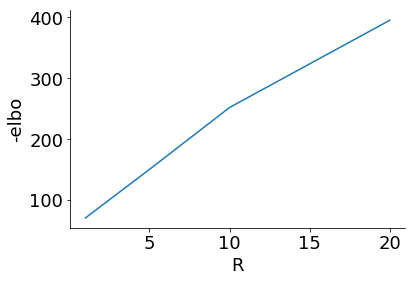

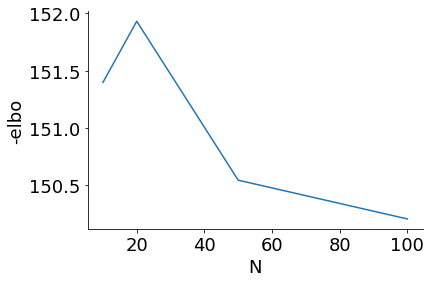

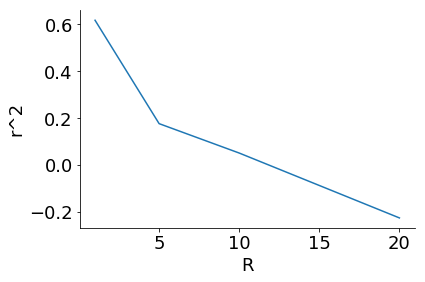

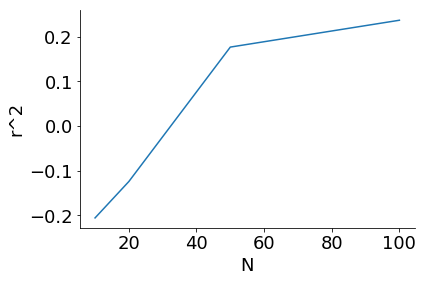

In [13]:
plt.figure();
plt.plot(Rs, VI_Rsweep_elbos[:,0]);
plt.xlabel('R')
plt.ylabel('-elbo')
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show();

plt.figure();
plt.plot(Ns, VI_Nsweep_elbos[:,0]);
plt.xlabel('N')
plt.ylabel('-elbo')
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show();

plt.figure();
plt.plot(Rs, VI_Rsweep_R2s[:,0]);
plt.xlabel('R')
plt.ylabel('r^2')
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show();

plt.figure();
plt.plot(Ns, VI_Nsweep_R2s[:,0]);
plt.xlabel('N')
plt.ylabel('r^2')
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show();


In [20]:
import tensorflow as tf
exp_fam = 'prp_tn';
D = 20;
K = 100;
M = 1000;
flow_id = '30P';
L = 8;
rs = 0;


savedir = '/Users/sbittner/Documents/efn/results/Fig5/EFN_%s_stochasticEta_giveInv_D=%d_K=%d_M=%d_flow=%s_L=%d_rs=%d/' \
          % (exp_fam, D, K, M, flow_id, L, rs);

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
sess = tf.Session();
new_saver = tf.train.import_meta_graph(savedir + 'model.meta');
new_saver.restore(sess, tf.train.latest_checkpoint(savedir));
Z0 = tf.get_collection('Z0')[0];
X = tf.get_collection('X')[0];
eta = tf.get_collection('eta')[0];
log_p_zs = tf.get_collection('log_p_zs')[0];
param_net_input = tf.get_collection('param_net_input')[0];
Tx_input = tf.get_collection('Tx_input')[0];

INFO:tensorflow:Restoring parameters from /Users/sbittner/Documents/efn/results/Fig5/EFN_prp_tn_stochasticEta_giveInv_D=20_K=100_M=1000_flow=30P_L=8_rs=0/model


In [32]:
def computeMoments(X, exp_fam, D, T, Z_by_layer, Tx_input):
    X_shape = tf.shape(X);
    K = X_shape[0];
    M = X_shape[1];
    if (T==1):
        if (exp_fam == 'normal'):
            cov_con_mask = np.triu(np.ones((D,D), dtype=np.bool_), 0);
            X_flat = tf.reshape(tf.transpose(X, [0, 1, 3, 2]), [K, M, D]); # samps x D
            Tx_mean = X_flat;
            XXT = tf.matmul(tf.expand_dims(X_flat, 3), tf.expand_dims(X_flat, 2));
            Tx_cov = tf.transpose(tf.boolean_mask(tf.transpose(XXT, [2,3,0,1]), cov_con_mask), [1, 2, 0]);
            Tx = tf.concat((Tx_mean, Tx_cov), axis=2);
        elif (exp_fam == 'dirichlet'):
            X_flat = tf.reshape(tf.transpose(X, [0, 1, 3, 2]), [K, M, D]); # samps x D
            Tx_log = tf.log(X_flat);
            Tx = Tx_log;
        elif (exp_fam == 'inv_wishart'):
            Dsqrt = int(np.sqrt(D));
            cov_con_mask = np.triu(np.ones((Dsqrt,Dsqrt), dtype=np.bool_), 0);
            X = X[:,:,:,0]; # update for T > 1
            X_KMDsqrtDsqrt = tf.reshape(X, (K,M,Dsqrt,Dsqrt));
            X_inv = tf.matrix_inverse(X_KMDsqrtDsqrt);
            Tx_inv = tf.transpose(tf.boolean_mask(tf.transpose(X_inv, [2,3,0,1]), cov_con_mask), [1, 2, 0]);
            # We already have the Chol factor from earlier in the graph
            zchol = Z_by_layer[-2];
            zchol_KMD_Z = zchol[:,:,:,0]; # generalize this for more time points
            L = tf.contrib.distributions.fill_triangular(zchol_KMD_Z);
            L_pos_diag = tf.contrib.distributions.matrix_diag_transform(L, tf.exp)
            L_pos_diag_els = tf.matrix_diag_part(L_pos_diag);
            Tx_log_det = 2*tf.reduce_sum(tf.log(L_pos_diag_els), 2);
            Tx_log_det = tf.expand_dims(Tx_log_det, 2);
            Tx = tf.concat((Tx_inv, Tx_log_det), axis=2);
        elif (exp_fam == 'prp_tn'):
            prior_Tx = computeMoments(X, 'normal', D, T, Z_by_layer, Tx_input);
            logz = tf.log(X[:,:,:,0]);
            sumz = tf.expand_dims(tf.reduce_sum(X[:,:,:,0], 2), 2);
            poisson_likelihood_Tx = tf.concat((logz, sumz), axis=2);
            Tx = tf.concat((prior_Tx, poisson_likelihood_Tx), 2);
        elif (exp_fam == 'dir_dir'):
            logz = tf.log(X[:,:,:,0]);
            beta = tf.expand_dims(Tx_input, 1);
            betaz = tf.multiply(beta, X[:,:,:,0]);
            log_gamma_beta_z = tf.lgamma(betaz);
            Tx = tf.concat((logz, betaz, log_gamma_beta_z), 2);
        elif (exp_fam == 'dir_mult'):
            logz = tf.log(X[:,:,:,0]);
            Tx = logz
        else:
            raise NotImplementedError;
    else:
        raise NotImplementedError; 
    return Tx;

def cost_fn(eta, log_p_zs, Tx, K_eta, cost_type):
    y = log_p_zs;
    R2s = [];
    costs = [];
    for k in range(K_eta):
        # get eta-specific log-probs and T(x)'s
        y_k = tf.expand_dims(y[k,:], 1);
        Tx_k = Tx[k,:,:];
        eta_k = tf.expand_dims(eta[k,:], 1);
        # compute optimial linear regression offset term for eta
        alpha_k = tf.reduce_mean(y_k - (tf.matmul(Tx_k, eta_k)));
        residuals = y_k - (tf.matmul(Tx_k, eta_k)) - alpha_k;
        RSS_k = tf.matmul(tf.transpose(residuals), residuals);
        y_k_mc = y_k - tf.reduce_mean(y_k);
        TSS_k = tf.reduce_sum(tf.square(y_k_mc));
        # compute the R^2 of the exponential family fit
        R2s.append(1.0 - (RSS_k[0,0] / TSS_k));
        costs.append(tf.reduce_mean(y_k - (tf.matmul(Tx_k, eta_k))));

    y = tf.expand_dims(log_p_zs, 2);
    eta = tf.expand_dims(eta, 2);
    cost = tf.reduce_sum(tf.reduce_mean(y - (tf.matmul(Tx, eta) ), [1,2]));
    #return cost, costs, R2s;
    return cost, costs, R2s;

Tx = computeMoments(X, exp_fam, D, 1, [], Tx_input)
cost, costs, R2s = cost_fn(eta, log_p_zs, Tx, 100, 'KL');


In [38]:
import scipy.io as sio
from efn_util import get_ef_dimensionalities, prp_tn_eta
D = 20;
def get_GP_Sigma(tau, T, Ts):
    K = np.zeros((T, T));
    for i in range(T):
        for j in range(i,T):
            diff = (i-j)*Ts;
            K[i,j] = np.exp(-(np.abs(diff)**2) / (2*(tau**2)));
            if (i != j):
                K[j,i] = K[i,j];
    return K;

mu = 0.2*np.ones((D,));
Ts = .02;
tau = .025;
Sigma = 0.26*get_GP_Sigma(tau, D, Ts);

datapath = '/Users/sbittner/Documents/efn/data/spike_counts_neuron4.mat';
data = sio.loadmat(datapath);
datax = data['x'];
textx = datax[100:,:];
extrastr = 'R=%d_N=%d_' % (R,N);
model_info = {'subclass':'VI', 'extrastr':extrastr, 'R':R, 'trainx':datax[:N,:], 'testx':datax[100:,:]};

D_Z, ncons, num_param_net_inputs, num_Tx_inputs = get_ef_dimensionalities(exp_fam, D, model_info, True);

K = 100;
EFN_R2s = np.zeros((num_Rs, K));
EFN_elbos = np.zeros((num_Rs, K));
for i in range(num_Rs):
    R = Rs[i];
    print(i, R);
    
    _eta = np.zeros((K, ncons));
    _param_net_input = np.zeros((K, num_param_net_inputs));
    _Tx_inputs = np.zeros((K, num_Tx_inputs));

    h1h2 = np.zeros((K,));
    for k in range(K):
        x = model_info['testx'];
        samp_inds = np.random.choice(x.shape[0], R, False);
        x = x[samp_inds,:D].T;
        fact_x_i = np.zeros((D,R));
        for j in range(D):
            for jj in range(R):
                fact_x_i[j] = np.math.factorial(x[j, jj]);
        h1h2[k] = np.log(np.prod(np.prod(fact_x_i)) / ((2*np.pi)**(D/2)))
        eta_k, param_net_input_k = prp_tn_eta(mu, Sigma, x, R, True);
        _eta[k,:] = eta_k;
        _param_net_input[k,:] = param_net_input_k;

    M = 1000;
    z0 = np.random.normal(0,1,(K,M,D,1));
    feed_dict = {Z0:z0, eta:_eta, param_net_input:_param_net_input};
    print('gen through tf');
    _costs, _R2s = sess.run([costs, R2s], feed_dict);
    
    A1 = np.dot(mu.T, np.dot(np.linalg.inv(Sigma), mu))/2.0 + np.log(np.linalg.det(Sigma));
    for k in range(K):           
        _costs[k] = _costs[k] + h1h2[k] - A1;
    _elbos = _costs;
    EFN_R2s[i,:] = _R2s;
    EFN_elbos[i,:] = _elbos;
    print('done');
    
print(EFN_R2s);
print(EFN_elbos);

0 1
gen through tf
done
1 5
gen through tf
done
2 10
gen through tf
done
3 20
gen through tf
done
[[0.65716202 0.72347424 0.6772636  0.65281714 0.6922597  0.58874936
  0.6542335  0.65342698 0.66550871 0.6562994  0.66003315 0.59468778
  0.70685076 0.62710764 0.67212093 0.70468847 0.61475333 0.62829
  0.58729628 0.59164569 0.68795084 0.63882704 0.67218291 0.61188306
  0.63141776 0.64529125 0.63124682 0.60618565 0.6104333  0.67297139
  0.56384645 0.68353172 0.60541399 0.62705708 0.6678433  0.64925124
  0.7160291  0.67838717 0.61320754 0.71420649 0.73099947 0.65014226
  0.63748818 0.70811081 0.67603681 0.67225312 0.70646442 0.63571997
  0.56499893 0.69461924 0.6595774  0.67572971 0.69290483 0.61880581
  0.6463826  0.66219225 0.67359766 0.68743676 0.63943603 0.60436573
  0.67509944 0.66120313 0.74271846 0.69707963 0.67204506 0.68580041
  0.70571067 0.6894113  0.6959939  0.69592543 0.6223906  0.68486433
  0.64455734 0.67554061 0.66669747 0.71198056 0.6654512  0.67663
  0.68983866 0.63996124 

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


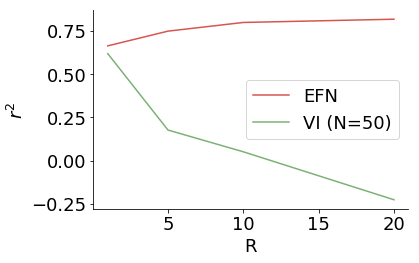

In [58]:
colors = ["pale red", "medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];
palette = sns.xkcd_palette(colors)

mean_R2s = np.mean(EFN_R2s, 1);
std_R2s = np.std(EFN_R2s, 1);

mean_elbos = np.mean(EFN_elbos, 1);
std_elbos = np.std(EFN_elbos, 1);

plt.figure();
plt.plot(Rs, mean_R2s, color=palette[0]);
plt.plot(Rs, VI_Rsweep_R2s[:,0], color=palette[6]);
plt.xlabel('R');
plt.ylabel(r'$r^2$')
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.legend(['EFN', 'VI (N=50)']);
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig5/%s_R2_Rsweep.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


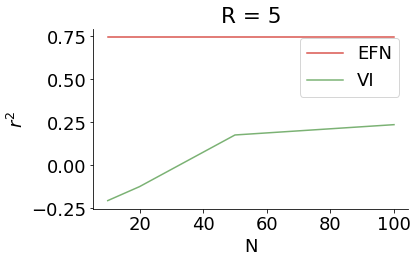

In [59]:
plt.figure();
plt.plot(Ns, mean_R2s[1]*np.ones(4,), color=palette[0]);
plt.plot(Ns, VI_Nsweep_R2s[:,0], color=palette[6]);
plt.xlabel('N');
plt.ylabel(r'$r^2$')
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('R = 5')
plt.legend(['EFN', 'VI']);
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig5/%s_R2_Nsweep.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

